# OMSCS Course Interest Study

The purpose of this project is to asses how well the OMSCS program is meeting the enrollment interests of its students.

The Georgia Tech Online Masters in Computer Science (OMSCS) program has gone through great effort to produce a flexible online CS masters degree program that is intended to be highly accessible. There are some great benefits to doing things at a large scale, but this is not without consequences. 

One of the biggest structural issues working at this scale is the registration process. Although the courses I've taken so far have been of great quality, I did not manage to get into my first two courses until very late in the registration process. In the first course I took in the program I only got into the course I wanted by switching classes after the course had already begun. This extra stress seems unnecessary, and it's not clear how GT will manage this going forward.

When the dust settles at the end of registration, most students typically end up in a class they want, but the uncertainty can be difficult to accept. Even then, for the most coveted courses, there are always students who don't get in. One of the best examples of this is the Graduate Algorithms course, 8803. Many need to take this course for their [specialization](https://www.omscs.gatech.edu/program-info/specializations), but it can be very difficult to enroll. Some students report being waitlisted for multiple different semesters. Often it is that last class a student needs before graduation, and for them, they can often get an advisor to give them priority waitlist positioning. These challenges are made worse by the fact that the course has a relatively high fail/retake rate.

For Fall 2018, the program has changed the number of courses a student may enroll in at a given time. If the student has completed fewer than four courses, then they may only register for a maximum of two courses. If the student has completed more than four courses they may add a third in a given semester with advisor approval. This may have multiple consequences. I expect one of the biggest consequences, and one of the likely motivators for this decision is to reduce the oversubscription rate during registration. This may also result in fewer students dropping courses during the semester, as it's common for newer students to underestimate the amount of effor required for each course.

This study should help better answer the common questions about a students chances of getting into a course given their waitlist position. It should also help make bottlenecks more obvious. Idealy this would lead to structural changes in the program, but with the running jokes about [future courses](https://www.omscs.gatech.edu/future-courses), I won't hold my breath.

Example dataset covers start of Fall 2018 Phase II registration

Written by:
Carlin Kartchner

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set fields that may change to analyze different semesters/data sets

# Semster label used on tables within the database
semester = 'F18'
dbname = "OMSCS_CA.db"
# Date range of interest
sdate = '2018-08-06'
edate = '2018-08-08'
# Enrollment numbers from spring 2018. 
# Enrollment numbers Fall 2018 TBD at time of notebook construction
# https://www.omscs.gatech.edu/prospective-students/numbers
tot_enrollment = 6365
course_enrollment = 8737

In [3]:
# Get all tables
conn = sqlite3.connect(dbname)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = cursor.fetchall()
# print("Course_tables")
# print(course_tables)

In [4]:
# Flatten tables list and take only indivudial classes tables (Ignore courses table)
course_tables = [el for row in tables for el in row if el[:3] == semester]
# Use Machine Learning course as reference data frame
ref_df = pd.read_sql_query(f"SELECT * FROM {semester}_87100", 
                           conn, 
                           index_col='Timestamp',
                           parse_dates=['Timestamp']
                          )  # Machine Learning
# Adjust ref index date range
ref_df = ref_df.loc[sdate:edate]

In [5]:
# Generate column names for the data

# The SQL WHERE option here does not work, so I filter in for loop below
# ctable = pd.read_sql_query("SELECT CRN, Crse, Sec FROM coursesF18 WHERE Sec <> OAN", conn)
ctable = pd.read_sql_query(f"SELECT CRN, Crse, Sec, Title FROM courses{semester}", conn)
cmap = {}  # Mapping of CRN to Crse
for row in ctable.itertuples():
    # OAN courses are MS Analytics only -- Ignore
    if row[3] != 'OAN':
        cmap[row[1]] = row[2]
# Most students know courses by their Crse number, not CRN
# Setup column index to increase intuition
# TBD: add commonly used acronymns for courses to column names
col_names = []
for key, value in cmap.items():
    col_names.append(f"{value}-{key}")
    


In [6]:
# Display course names
# TBD: adjust alignment
print(ctable.loc[:, ["Crse","CRN","Title"]])

    Crse    CRN                                        Title
0   6035  87766                       Intro To Info Security
1   6200  90882                         Graduate Intro to OS
2   6210  87097                        Adv Operating Systems
3   6250  87098                            Computer Networks
4   6262  88544                             Network Security
5   6263  91374                     Intro Cyber Phys Sys Sec
6   6290  87102                     High Perform Comput Arch
7   6291  90883                       Embedded Software Opt.
8   6300  87099                         Software Dev Process
9   6310  87103                       Software Arch & Design
10  6340  88539                     Software Analysis & Test
11  6400  88540                      DB Sys Concepts& Design
12  6400  90285                      DB Sys Concepts& Design
13  6440  87104                     Intro Health Informatics
14  6460  88001                        Educ Tech-Foundations
15  6475  87764         

In [7]:
# Build dataframe with 'interest' data for all courses
plot_index = ref_df.index
interest_df = pd.DataFrame(data=np.nan, index=plot_index, columns=col_names)
wl_df = pd.DataFrame(data=np.nan, index=plot_index, columns=col_names)
act_df = pd.DataFrame(data=np.nan, index=plot_index, columns=col_names)
sum_df = pd.DataFrame(data=np.nan, index=plot_index, columns=["WL+Act","WL","Act"])
for course in course_tables:
    crn = course[4:]
    if crn in cmap:
        tmp_tbl = pd.read_sql_query(f"SELECT Timestamp, Act, WL_Act from {course}", 
                                    conn, 
                                    index_col='Timestamp',
                                    parse_dates=['Timestamp']
                                   )
        # Convert strings from db to appropriate data type
        tmp_tbl[['Act','WL_Act']] = tmp_tbl[['Act','WL_Act']].apply(pd.to_numeric)
        col = f"{cmap[crn]}-{crn}"
        interest_df[col] = tmp_tbl['Act'] + tmp_tbl['WL_Act']
        wl_df[col] = tmp_tbl['WL_Act']
        act_df[col] = tmp_tbl['Act']
interest_df = interest_df.dropna()
wl_df = wl_df.dropna()
act_df = act_df.dropna()
sum_df['WL+Act'] = interest_df.sum(axis=1)
sum_df['WL'] = wl_df.sum(axis=1)
sum_df['Act'] = act_df.sum(axis=1)
sum_df = sum_df.dropna()

In [8]:
# Sort df columns by interest on the last day
# This is useful for ordering the final legend
interest_lastday = interest_df.iloc[-1].sort_values(ascending=False)
lastday_col_sort = list(interest_lastday.index)
interest_df = interest_df.reindex(lastday_col_sort, axis=1)

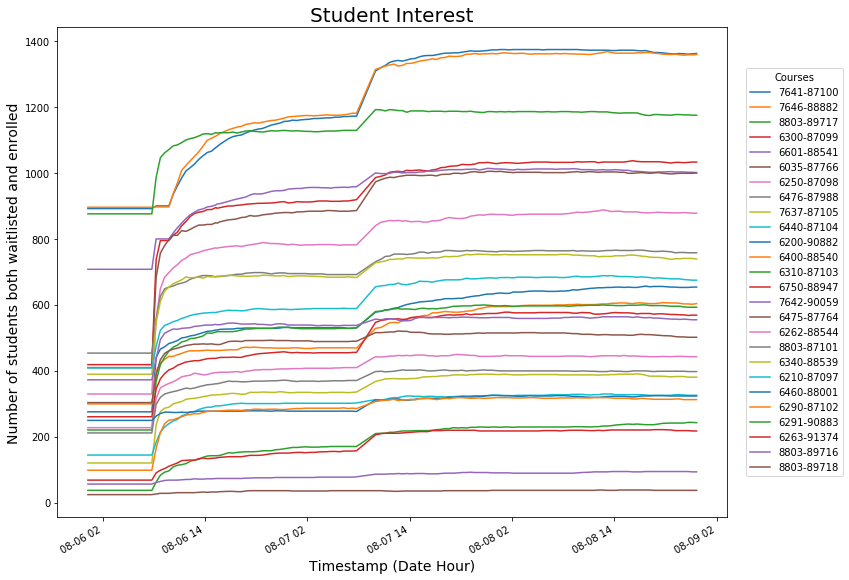

In [9]:
# Plot interest level for each course over time
# figsize : a tuple (width, height) in inches  
# *inches is odd unit and baked into matplotlib*
int_plot = interest_df.plot(figsize = (12,10))
plt.ylabel("Number of students both waitlisted and enrolled", fontsize = 14)
plt.xlabel("Timestamp (Date Hour)", fontsize = 14)
plt.title("Student Interest", fontsize = 20)
plt.legend(loc='center right', bbox_to_anchor=(1.18, 0.5), title='Courses')
plt.show()

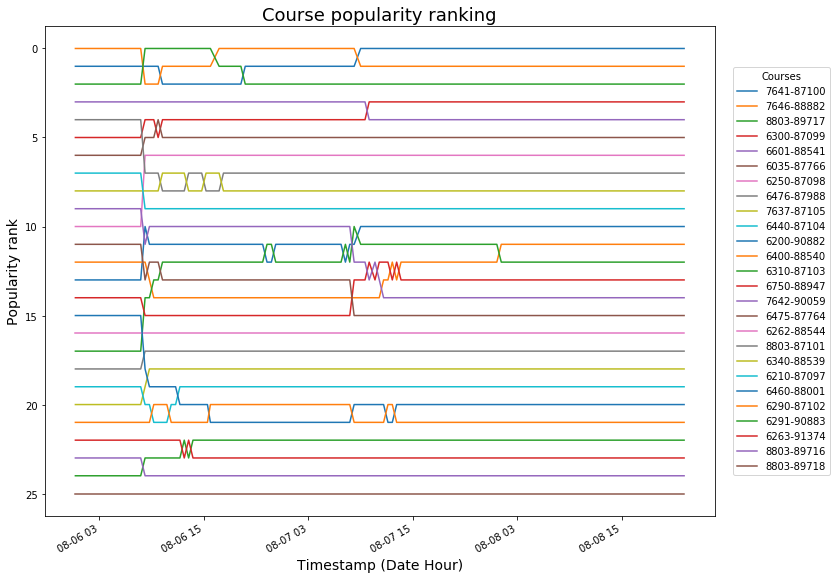

In [10]:
# How course popularity changes with different registration windows
rank_df = pd.DataFrame(data=np.nan, index=ref_df.index, columns=lastday_col_sort)
interest_lastday = interest_df.iloc[-1].sort_values(ascending=False)
# Build ranked dataframe
for i in range(0,len(interest_df)):
    sorted_row = interest_df.iloc[i].sort_values(ascending=False)
    sorted_index = list(sorted_row.index)
    # Ignore days with incomplete data
    if np.isnan(sorted_row.iloc[-2]) == False:
        for col in col_names:
            rank_df.iloc[i][col] = sorted_index.index(col)
# Hide rows with missing values
rank_df = rank_df.dropna()
int_plot = rank_df.plot(figsize = (12,10))
plt.legend(loc='center right', bbox_to_anchor=(1.18, 0.5), title='Courses')
plt.gca().invert_yaxis()
plt.ylabel("Popularity rank", fontsize = 14)
plt.xlabel("Timestamp (Date Hour)", fontsize = 14)
plt.title("Course popularity ranking", fontsize = 18)
plt.show()

In [11]:
start_rank = rank_df.iloc[0]
end_rank = rank_df.iloc[-1]
movement = start_rank-end_rank
movement = movement.sort_values(ascending=False)
print("Course popularity rank change during\nregistration observation window:\n")
print(movement)

Course popularity rank change during
registration observation window:

6310-87103    5.0
6250-87098    4.0
6200-90882    3.0
6300-87099    2.0
6291-90883    2.0
6340-88539    2.0
6750-88947    1.0
6035-87766    1.0
6400-88540    1.0
7641-87100    1.0
8803-87101    1.0
6262-88544    0.0
6210-87097    0.0
7637-87105    0.0
6290-87102    0.0
8803-89717    0.0
8803-89718    0.0
8803-89716   -1.0
6601-88541   -1.0
6263-91374   -1.0
7646-88882   -1.0
6440-87104   -2.0
6476-87988   -3.0
6475-87764   -4.0
7642-90059   -5.0
6460-88001   -5.0
dtype: float64


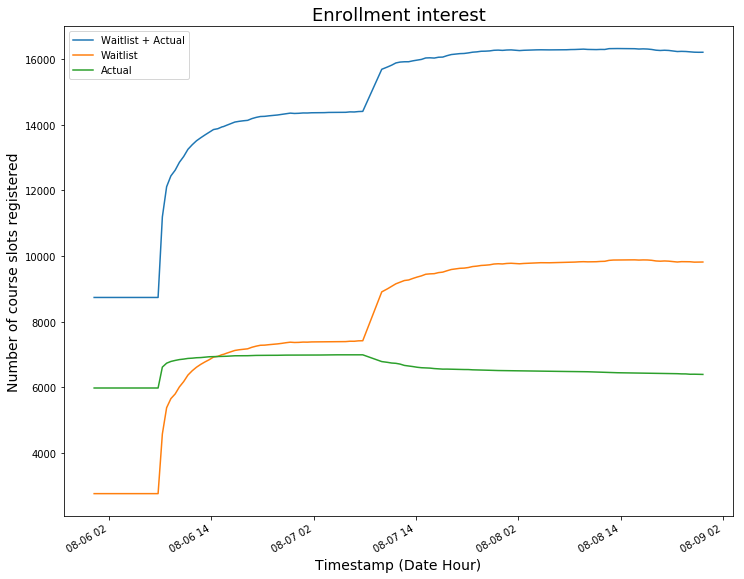

In [12]:
# Total enrollment interest over observation period
tot_interest = sum_df['WL+Act']
fig = sum_df.plot(figsize = (12,10))
plt.ylabel("Number of course slots registered", fontsize = 14)
plt.xlabel("Timestamp (Date Hour)", fontsize = 14)
plt.title("Enrollment interest", fontsize = 18)
fig.legend(labels=['Waitlist + Actual','Waitlist','Actual'])
plt.show()

In [13]:
# Oversubscription rate on last timestamp of observation range
# (Requires correct data for semester of interest to be set at beginning of notebook)
ioce = tot_interest.iloc[-1]/course_enrollment
ions = tot_interest.iloc[-1]/tot_enrollment
ldinterest = int(tot_interest.iloc[-1])
max_time = tot_interest.index[-1]
print("Time of last data point:")
print(f"  {max_time}")
print("Enrollment interest on last day of db range:")
print(f"  {ldinterest}")
print("Average number of courses each student is interested in:")
print(f"  {ions:.2f}")
print("Average number of courses students are interested in v. final enrollment:")
print(f"  {ioce:.2f}")


Time of last data point:
  2018-08-08 23:39:29.506431
Enrollment interest on last day of db range:
  16209
Average number of courses each student is interested in:
  2.55
Average number of courses students are interested in v. final enrollment:
  1.86


In [14]:
# Peak oversubscription
max_time = tot_interest.idxmax()
max_interest = int(tot_interest.loc[max_time])
ioce = tot_interest.loc[max_time]/course_enrollment
ions = tot_interest.loc[max_time]/tot_enrollment
print("Time of max interest:")
print(f"  {max_time}")
print("Max enrollment interest:")
print(f"  {max_interest}")
print("Average number of courses each student is interested in:")
print(f"  {ions:.2f}")
print("Average number of courses students are interested in v. final enrollment:")
print(f"  {ioce:.2f}")

Time of max interest:
  2018-08-08 13:39:29.038891
Max enrollment interest:
  16322
Average number of courses each student is interested in:
  2.56
Average number of courses students are interested in v. final enrollment:
  1.87
